In [118]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torch import nn, optim
from time import time

In [119]:
#import data from MNIST using pytorch
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
main_data_set = datasets.MNIST('~/.pytorch/MNIST/',download=True,train=True,transform = transform)
# test_data = datasets.MNIST('~/.pytorch/MNIST/',download=True,train=False)


In [120]:
print(len(main_data_set))

60000


In [121]:
#train Test Validation Split
train_size = int(0.7 * len(main_data_set))
temp_size = len(main_data_set) - train_size
train_dataset, temp_dataset = torch.utils.data.random_split(main_data_set, [train_size, temp_size])
validation_size = int(0.5 * len(temp_dataset))
test_size = len(temp_dataset) - validation_size
validation_dataset, test_dataset = torch.utils.data.random_split(temp_dataset, [validation_size, test_size])

In [122]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

42000
9000
9000


In [123]:
#Loader Creation

trainloader = torch.utils.data.DataLoader(train_dataset,batch_size =11,shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset,batch_size = 11,shuffle=True)
Testloader = torch.utils.data.DataLoader(test_dataset,batch_size=11,shuffle = True)

In [124]:
#validation of Split dataset
data_iter = iter(trainloader)
images,labels = data_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([11, 1, 28, 28])
torch.Size([11])


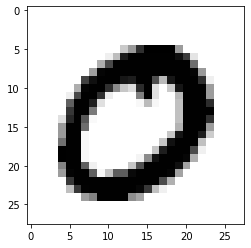

In [125]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

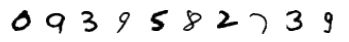

In [126]:
figure = plt.figure()
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [127]:
#Define Model
input_size = 28*28
internal_layer_size = 30
output_size = 10

model = nn.Sequential(nn.Linear(input_size,internal_layer_size),nn.Sigmoid(),nn.Linear(internal_layer_size,output_size),nn.Sigmoid())
print(model)


Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=10, bias=True)
  (3): Sigmoid()
)


# MSE LOSS

In [128]:
# Loss Function 
criterion_MSE = nn.MSELoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
logps = model(images) #log probabilities
loss = criterion_MSE(logps, torch.nn.functional.one_hot(labels,num_classes=10).to(torch.float)) #calculate the MSE loss
#print(torch.nn.functional.one_hot(labels).to(torch.float))
print(loss)

tensor(0.2281, grad_fn=<MseLossBackward0>)


In [129]:
#loss function validation
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [-0.0016, -0.0016, -0.0016,  ..., -0.0016, -0.0016, -0.0016],
        [-0.0016, -0.0016, -0.0016,  ..., -0.0016, -0.0016, -0.0016],
        ...,
        [ 0.0028,  0.0028,  0.0028,  ...,  0.0028,  0.0028,  0.0028],
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004]])


In [130]:
#training the model

optimizer = optim.SGD(model.parameters(),lr=0.003,momentum=0.9)
time0 = time()
epochs = 20 

for i in range(epochs):
    running_loss = 0
    for images,labels in trainloader:
        images = images.view(images.shape[0],-1)     
        optimizer.zero_grad()
        
        output = model(images)
        loss= criterion_MSE(output,torch.nn.functional.one_hot(labels,num_classes=10).to(torch.float))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i, loss.item()))  
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 0.0885181874036789
Epoch 1 - Training loss: 0.08441909402608871
Epoch 2 - Training loss: 0.08487170189619064
Epoch 3 - Training loss: 0.08864355087280273
Epoch 4 - Training loss: 0.042106322944164276
Epoch 5 - Training loss: 0.04920416325330734
Epoch 6 - Training loss: 0.06486959010362625
Epoch 7 - Training loss: 0.048369478434324265
Epoch 8 - Training loss: 0.049647461622953415
Epoch 9 - Training loss: 0.03962340205907822
Epoch 10 - Training loss: 0.06736971437931061
Epoch 11 - Training loss: 0.028125038370490074
Epoch 12 - Training loss: 0.03456563502550125
Epoch 13 - Training loss: 0.03965029492974281
Epoch 14 - Training loss: 0.04043184965848923
Epoch 15 - Training loss: 0.047869496047496796
Epoch 16 - Training loss: 0.006566725671291351
Epoch 17 - Training loss: 0.10853858292102814
Epoch 18 - Training loss: 0.005426289048045874
Epoch 19 - Training loss: 0.0367211177945137

Training Time (in minutes) = 2.395744800567627


In [131]:
#validation Check
correct_count, all_count = 0, 0
for images,labels in validationloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nValidation Model Accuracy with MSE Loss function =", 100 * (correct_count/all_count))

Number Of Images Tested = 9000

Validation Model Accuracy with MSE Loss function = 89.54444444444445


In [132]:
#Test Check
correct_count, all_count = 0, 0
for images,labels in Testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    #print(pred_label,true_label)
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nTest Model Accuracy with MSE Loss function=", 100 * (correct_count/all_count))

Number Of Images Tested = 9000

Test Model Accuracy with MSE Loss function= 89.57777777777778


# CrossEntropyLoss

In [133]:
#criterion_CrossEntropy Loss creation
criterion_CrossEntropy = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
logps = model(images) #log probabilities
loss = criterion_CrossEntropy(logps, torch.nn.functional.one_hot(labels,num_classes=10).to(torch.float)) #calculate the NLL loss
#print(torch.nn.functional.one_hot(labels).to(torch.float))
print(loss)

tensor(1.6959, grad_fn=<DivBackward1>)


In [134]:
#Loss validation
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 tensor([[ 1.3571e-03,  1.3571e-03,  1.3571e-03,  ...,  1.3571e-03,
          1.3571e-03,  1.3571e-03],
        [ 3.3887e-03,  3.3887e-03,  3.3887e-03,  ...,  3.3887e-03,
          3.3887e-03,  3.3887e-03],
        [ 3.9076e-03,  3.9076e-03,  3.9076e-03,  ...,  3.9076e-03,
          3.9076e-03,  3.9076e-03],
        ...,
        [-5.2860e-06, -5.2860e-06, -5.2860e-06,  ..., -5.2860e-06,
         -5.2860e-06, -5.2860e-06],
        [-1.9892e-03, -1.9892e-03, -1.9892e-03,  ..., -1.9892e-03,
         -1.9892e-03, -1.9892e-03],
        [ 1.3975e-04,  1.3975e-04,  1.3975e-04,  ...,  1.3975e-04,
          1.3975e-04,  1.3975e-04]])
After backward pass: 
 tensor([[-5.7197e-05, -5.7197e-05, -5.7197e-05,  ..., -5.7197e-05,
         -5.7197e-05, -5.7197e-05],
        [ 7.0909e-03,  7.0909e-03,  7.0909e-03,  ...,  7.0909e-03,
          7.0909e-03,  7.0909e-03],
        [ 8.6884e-03,  8.6884e-03,  8.6884e-03,  ...,  8.6884e-03,
          8.6884e-03,  8.6884e-03],
        ...,

In [135]:
#Training data on Cross Entropy Loss
optimizer = optim.SGD(model.parameters(),lr=0.003,momentum=0.9)
time0 = time()
epochs = 20 

for i in range(epochs):
    running_loss = 0
    for images,labels in trainloader:
        images = images.view(images.shape[0],-1)     
        optimizer.zero_grad()
        
        output = model(images)
        loss= criterion_CrossEntropy(output,torch.nn.functional.one_hot(labels,num_classes=10).to(torch.float))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i, loss.item()))  
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 1.5345172882080078
Epoch 1 - Training loss: 1.509224772453308
Epoch 2 - Training loss: 1.6433229446411133
Epoch 3 - Training loss: 1.4898617267608643
Epoch 4 - Training loss: 1.5026359558105469
Epoch 5 - Training loss: 1.4859999418258667
Epoch 6 - Training loss: 1.482060194015503
Epoch 7 - Training loss: 1.5025275945663452
Epoch 8 - Training loss: 1.5412571430206299
Epoch 9 - Training loss: 1.4823377132415771
Epoch 10 - Training loss: 1.7264370918273926
Epoch 11 - Training loss: 1.8046472072601318
Epoch 12 - Training loss: 1.9749956130981445
Epoch 13 - Training loss: 1.4718983173370361
Epoch 14 - Training loss: 2.175966262817383
Epoch 15 - Training loss: 1.9189342260360718
Epoch 16 - Training loss: 1.475761890411377
Epoch 17 - Training loss: 1.4820291996002197
Epoch 18 - Training loss: 1.5221927165985107
Epoch 19 - Training loss: 1.4860000610351562

Training Time (in minutes) = 2.684967033068339


In [136]:
#Validation Check
correct_count, all_count = 0, 0
for images,labels in validationloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)  
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nValidation Model Accuracy with Cross Entropy Loss=", 100 * (correct_count/all_count))

Number Of Images Tested = 9000

Validation Model Accuracy with Cross Entropy Loss= 92.4


In [137]:
#Test Check
correct_count, all_count = 0, 0
for images,labels in Testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    #print(pred_label,true_label)
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\Test Model Accuracy with Cross Entropy Loss =", 100 * (correct_count/all_count))

Number Of Images Tested = 9000
\Test Model Accuracy with Cross Entropy Loss = 92.5111111111111
